# 2. What are the main descriptive dimensions along which listeners describe expressive performance?

In this notebook (corresponding to Section 4 in the paper) we compute a possibility for expressive character dimensions (Section 4 in the paper) form based on the preprocessed term usage distribution in the Con Espressione Game.

In the rest of this notebook is structured as follows:

1. Loading the raw Con Espressione Game data
2. Preprocessing
3. Principal Component Analysis and Visualization

This notebook requires numpy, pandas, scikit-learn, and matplotlib.

The Con Espressione Game Data is available at: https://zenodo.org/record/3968828

In [453]:
import warnings
warnings.filterwarnings("ignore")

In [454]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

In [455]:
from __future__ import print_function
import pandas as pd
import copy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA

# DATA LOADING

Download data from https://zenodo.org/record/3968828 
In this notebook, we are using the file con_espressione_game_answers.csv exclusively. After downloading, change path/to/con_espressione_game_dataset/con_espressione_game_answers.csv below.

In [498]:
# load data using pandas

df = pd.read_csv("/CHANGE/PATH//con_espressione_game_dataset/con_espressione_game_answers.csv")
list_of_w0 = ", ".join(df.answer).split(", ")
list_of_w = [w.strip().lower().replace(",","") for w in list_of_w0 ]
vocab = set(list_of_w)
print("Number of answers: ", len(df))
print("Number of words in the answers: ", len(list_of_w))
print("Number of unique words in the answers: ", len(vocab))

Number of answers:  1462
Number of words in the answers:  3331
Number of unique words in the answers:  1585


In [477]:
# Have a look at what the data looks like

df.head()

,answer_id,participant_id,music_id,answer,original_answer,timestamp,favorite,translated_to_english,performer,piece_name,performance_name
0,71,4,9,"slow, sad, clear_phrasing","slow, sad, clear phrasing",2018-02-16 12:43:42,NaN,NaN,Casadesus,beethoven,09_3_2_2_Beethoven_Casadesus_Cut2_01.38-03.03
1,94,7,9,"soft, tender","soft, tender",2018-02-16 14:14:39,NaN,NaN,Casadesus,beethoven,09_3_2_2_Beethoven_Casadesus_Cut2_01.38-03.03
2,130,10,9,ordinary,ordinary,2018-02-19 07:42:00,NaN,NaN,Casadesus,beethoven,09_3_2_2_Beethoven_Casadesus_Cut2_01.38-03.03
3,170,16,9,pacified,pacified,2018-03-04 13:44:56,NaN,NaN,Casadesus,beethoven,09_3_2_2_Beethoven_Casadesus_Cut2_01.38-03.03
4,235,36,9,blank,blank,2018-03-16 08:34:10,0.0,NaN,Casadesus,beethoven,09_3_2_2_Beethoven_Casadesus_Cut2_01.38-03.03


In [478]:
# Reduce to columns of interest

df_short = df[["music_id","answer","piece_name","performer"]]
df_short.head()

,music_id,answer,piece_name,performer
0,9,"slow, sad, clear_phrasing",beethoven,Casadesus
1,9,"soft, tender",beethoven,Casadesus
2,9,ordinary,beethoven,Casadesus
3,9,pacified,beethoven,Casadesus
4,9,blank,beethoven,Casadesus


In [479]:
# Aggregate the answers per unique performance (unique music_id)

aggregation_functions = {'answer': ', '.join, 'performer': max, 'piece_name': max}
df_new = df.groupby(df_short['music_id']).aggregate(aggregation_functions)
df_new.head()

,answer,performer,piece_name
music_id,,,
1,"floating, brisk, romantic, rebellious, fast, m...",Gieseking,bach
2,"mechanic, dancing, simplistic, staccato, mecha...",Gould,bach
3,"shy, magical, deep, delicate, sweet, longing, ...",Grimaud,bach
5,"hasty, nimble, unanimous, fast, mechanical, bo...",Kempff,bach
6,"searching, exploring, traditional, classical, ...",Richter,bach


In [480]:
# a list of pieces as they occur in df_new

pieces_list = list(df_new["piece_name"])
performer_list = list(df_new["performer"])
# unique pieces
pieces = list(set(df_new["piece_name"]))

# DATA PREPROCESSING

The data is preprocessed in several steps: answers in other languages are translated to English (not in this notebook) and terms are stemmed. A term is omitted if (1) it shows up less than three times in the dataset (its contribution to the global variance is minimal) or (2) it is used forall interpretations of the same piece (its piecewise entropy is  zero). Term usage per performance is capped before computing the PCA.

In [481]:
corpus1 = list(df_new.answer)
tf_matrix = CountVectorizer(strip_accents = 'unicode',
                            token_pattern=r"(?u)\b[^\s]+\b",
                                lowercase = True,
                                min_df =3)# minimal number of occurences
dtm = tf_matrix.fit_transform(corpus1)
print(dtm.shape)

(45, 216)


In [482]:
unique_tags_per_performance = np.sum((dtm>0), axis=1)
tags_per_performance = np.sum(dtm, axis=1)

In [483]:
# data shape: N performances / M terms <-> N observations / M variables <-> N samples / M features

data = dtm.toarray() 
tag_list = tf_matrix.get_feature_names()

In [484]:
# helper function to find terms used for less than all - limit performances

def once_per_piece_idx(data_array, limit = 1):
    all_pieces_doubles = []
    for ppp in range(len(pieces)): # loop over unique pieces
        maskp = (np.array(pieces_list) == pieces[ppp])
        data_idx = (data_array[maskp,:]>0) # get the occurence matrix related to a single piece
        all_pieces_doubles.append((np.sum(data_idx, axis = 0) > data_idx.shape[0]-limit)) 
        # TRUE = 1 at terms that are used more than all_perf - limit times
    once_per_piece_mask = (np.sum(np.array(all_pieces_doubles), axis = 0) > 0) 
    # TRUE = 1 at more than 1 occurence per piece in one piece at least
    
    print("percentage of terms used often: {0:.2f}%".format(once_per_piece_mask.sum()/len(once_per_piece_mask)*100))
    return once_per_piece_mask

# helper function to find terms used in all pieces

def in_all_piece_idx(data_array):
    
    tag_in_piece = np.zeros((len(pieces),dtm.shape[1]))
    for ppp in range(len(pieces)):
        maskp = (np.array(pieces_list) == pieces[ppp])
        tag_in_piece[ppp,:] = np.sum(dtm[maskp,:], axis=0)
    
    in_all_pieces = np.sum((tag_in_piece>0), axis=0)
    return in_all_pieces == len(pieces)

In [485]:
# get an idea of indiscriminately used terms

common_tags_idx = np.arange(0,len(tag_list))[once_per_piece_idx(data,2)] 
common_tags1 = np.array(tag_list)[common_tags_idx]
print("number of terms: ",len(common_tags_idx))
print(common_tags1)

percentage of terms used often: 7.87%
number of terms:  17
['boring' 'clear' 'dramatic' 'dynamic' 'emotional' 'expressive' 'fast'
 'happy' 'hard' 'heavy' 'interesting' 'light' 'mechanical' 'natural'
 'nice' 'soft' 'soft_start']


In [486]:
# get an idea of universally used terms

all_tags_idx = np.arange(0,len(tag_list))[in_all_piece_idx(data)] 
all_tags1 = np.array(tag_list)[all_tags_idx]
print("number of terms: ", len(all_tags_idx))
print(all_tags1)

number of terms:  7
['dynamic' 'expressive' 'fast' 'loud' 'mechanical' 'slow' 'soft']


In [487]:
# exclude indiscriminately used terms

data = np.delete(data, common_tags_idx, axis= 1)

# cap term usage per performance

data[data>1]=1.5
tag_list = list(np.delete(np.array(tag_list), common_tags_idx))
print(data.shape, len(tag_list))

(45, 199) 199


# PCA: PERFORMANCE observations wiht TERM variables

Reduce performance variables (= unique terms) to 4 major dimensions capturing the maximum variance

In [488]:
pca = PCA(n_components=4)
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [489]:
print("explained variance: ",pca.explained_variance_ratio_)
print("total explained variance ", pca.explained_variance_ratio_.sum())
print("singular values ", pca.singular_values_)

explained variance:  [0.09405447 0.0633868  0.0451725  0.03891689]
total explained variance  0.24153066597348677
singular values  [9.2163789  7.56606377 6.38715802 5.92842978]


In [490]:
# helper function to plot

def plotter(plotdata, annotations, color_idxs, piece_no, p_names, suffix=""):
    fig, ax = plt.subplots(figsize=(20,10))
    all_color_idx_list = list()
    clr_idxs_list
    for color_idx in color_idxs:
        all_color_idx_list += list(color_idx)
    all_color_idx = np.array(list(set(all_color_idx_list)))
    non_color_idx = np.delete(np.arange(0,plotdata.shape[0]), all_color_idx, axis=0)
    colors = cm.rainbow(np.linspace(0, 1, len(color_idxs)))
    
    # TERM SCATTER PLOT
    ax.scatter(plotdata[non_color_idx,0],plotdata[non_color_idx,1], s=10, c="black", alpha=0.3, marker='x')
    for k in range(len(color_idxs)):
        ax.scatter(plotdata[color_idxs[k],0],plotdata[color_idxs[k],1], s=50, c=colors[k:k+1,:], marker='o', label=p_names[k] )

    # TEXT ANNOTATION
    for i in range(plotdata.shape[0]):
        if i in all_color_idx:
            ax.annotate(annotations[i], (plotdata[i,0], plotdata[i,1]))
    # PERFORMANCE CENTROID        
    for k in range(len(color_idxs)):
        ax.scatter(plotdata[color_idxs[k],0].mean(),plotdata[color_idxs[k],1].mean(), s=20**2, c=colors[k:k+1,:], marker='D')  
        
    ax.title.set_text("embeddings {0} {1}".format(pieces[piece_no], suffix))  
    ax.legend(fontsize='medium')
    plt.plot()

    
# helper function to compute the performer names and term idx pertaining to a single piece   

def clr_idxs_list(number, data_array):
    piece_idx = (np.array(pieces_list) == pieces[number])[:]
    performer_names = np.array(performer_list)[piece_idx]
    data_idx = data_array[piece_idx,:]
    color_idxs = list()
    for perf in range(data_idx.shape[0]):
        color_idx = np.arange(0, data_array.shape[1])[(data_idx[perf,:] != 0.)]
        color_idxs.append(color_idx)
     
    return color_idxs, performer_names

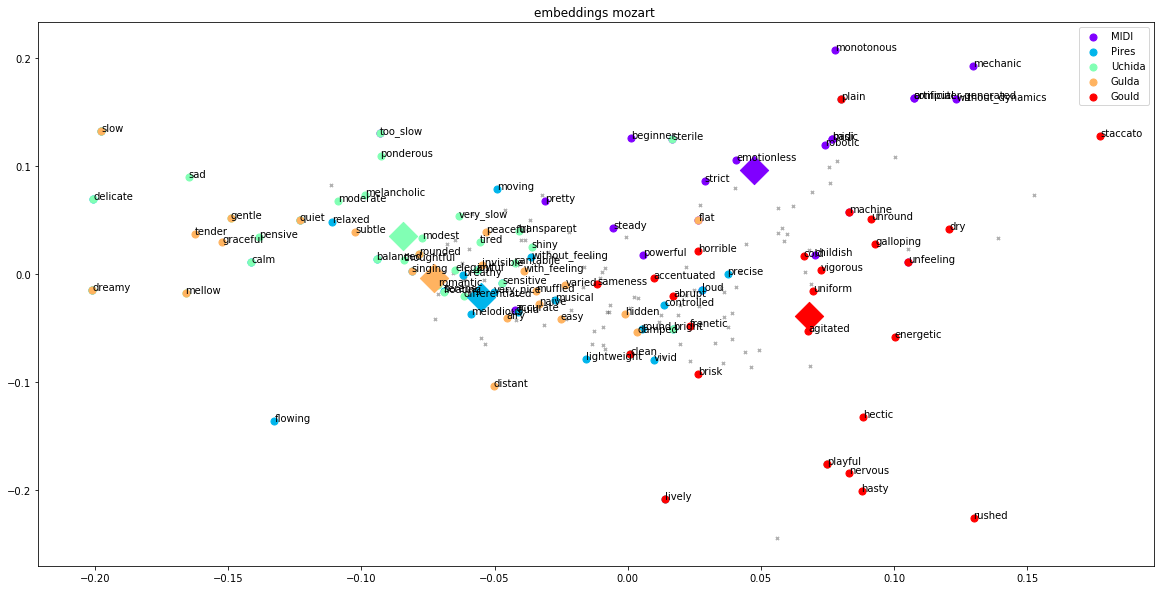

In [491]:
# visualize the result of the PCA

which_piece = 8  # change this value to see different piecewise term distributions plotted: 0-8 
color_idxs_d, perf_names = clr_idxs_list(which_piece, data[:,:])
plotter(pca.components_.T,
         tag_list, 
         color_idxs = color_idxs_d,
         piece_no = which_piece,
         p_names = perf_names)

In [492]:
def strong_tag_by_dim(emb, dim, tag_list=tag_list, num = 5):
    sort_idx = np.argsort(emb[dim,:])
    for k in range(num):
        print(np.array(tag_list)[sort_idx[-k-1]],emb[dim,sort_idx[-k-1]])
    print(" ")
    for k in range(num):
        print(np.array(tag_list)[sort_idx[k]],emb[dim,sort_idx[k]])
    print(" ")

In [493]:
# print the strongest (positive and negative) loading terms

for i in range(4):
    print("DIMENSION:", i+1)
    strong_tag_by_dim(pca.components_,i)

DIMENSION: 1
staccato 0.1775233625097122
aggressive 0.1525503138159206
chopped 0.13906746187647068
rushed 0.12989270264619748
mechanic 0.12956482568081593
 
dreamy -0.20099425013487568
delicate -0.20071563906438825
slow -0.1978001748513871
mellow -0.1660498146337268
sad -0.16491700494362385
 
DIMENSION: 2
monotonous 0.2081078312873944
mechanic 0.19321435809833856
artificial 0.16316119895115308
computer-generated 0.16316119895115302
plain 0.16275878258206175
 
too_fast -0.24399082228378352
rushed -0.22514454209773438
lively -0.2075602075714632
hasty -0.20063950351359622
nervous -0.18383655989168465
 
DIMENSION: 3
flowing 0.21741225273047757
dark 0.18518605375158462
warm 0.15602151074639484
gentle 0.15439764632740938
plain 0.15293183007533004
 
passionate -0.35350895603105315
slower -0.19747862757938972
slow -0.18478145385500938
tense -0.16538159925716062
ponderous -0.13511333025449132
 
DIMENSION: 4
clean 0.24063522838644263
very_nice 0.18513724589670966
lively 0.18209606854914448
joyfu

In [495]:
# save the PCA data for use with other notebooks

data3 = data/np.outer(np.sum(data, axis=1),np.ones(data.shape[1]))
# performance embeddings as weighted an nomralized sum of terms used in the description
perf_emb3 = np.matmul(data3,pca.components_.T)
df_embedding = pd.DataFrame(index = df_new.index, 
                            columns = ["dim_1", "dim_2", "dim_3", "dim_4"],
                            data = perf_emb3)
df_final = pd.concat([df_embedding, df_new], axis=1)
# save as csv file
df_final.to_csv("text_embeddings.csv")